In [1]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
colors = ["#a2c4e0", "#82a4e3", "#52688f", "#f7cb2d"]  # baby blue, cornflower light, cornflower, amber gold

In [3]:
df = pq.read_pandas(r"D:\DataSets\Partial Discharge Dataset-20230605T040721Z-003\Partial Discharge Dataset\train.parquet", columns=[str(i) for i in range(9)]).to_pandas()
df

,0,1,2,3,4,5,6,7,8
0,18,1,-19,-16,-5,19,-15,15,-1
1,18,0,-19,-17,-6,19,-17,16,0
2,17,-1,-20,-17,-6,19,-17,15,-3
3,18,1,-19,-16,-5,20,-16,16,0
4,18,0,-19,-16,-5,20,-17,16,-2
...,...,...,...,...,...,...,...,...,...
799995,19,2,-18,-15,-4,21,-16,16,-1
799996,19,1,-19,-15,-4,20,-17,15,-3
799997,17,0,-19,-15,-4,21,-16,14,-2
799998,19,1,-18,-14,-3,22,-16,17,-1


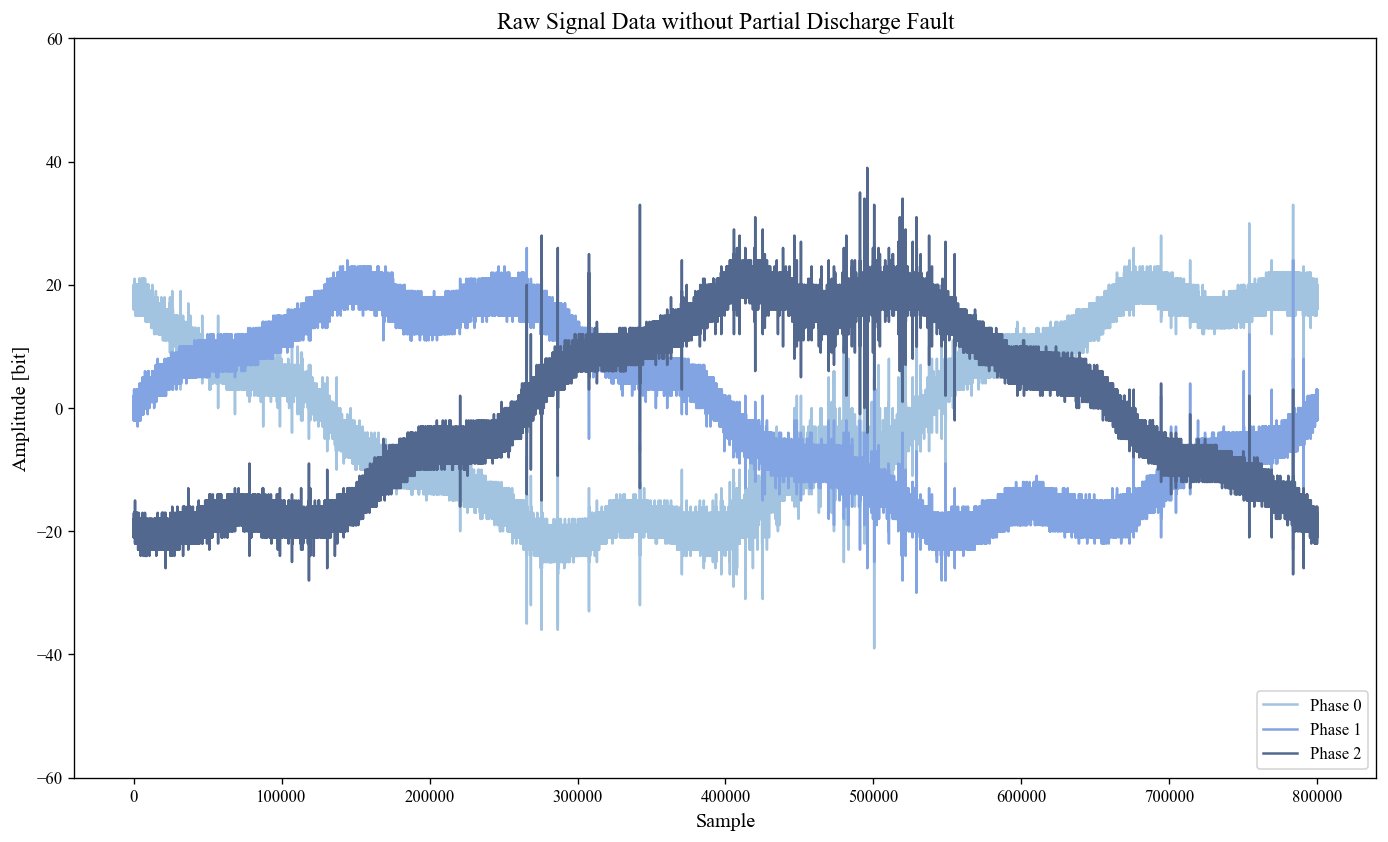

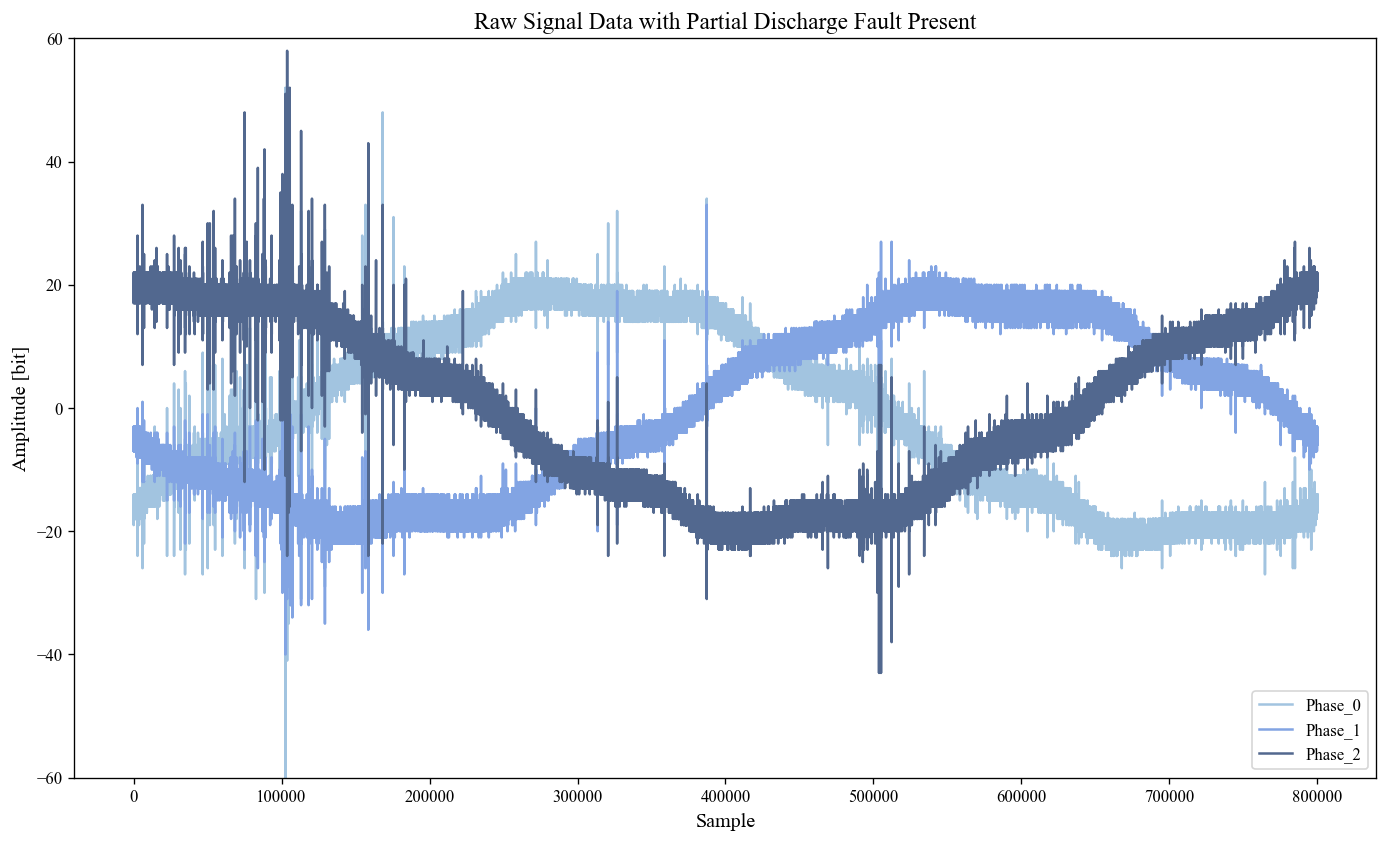

In [4]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase 0', 'Phase 1', 'Phase 2']

plt.plot(list(range(len(df))), df["0"], '-', label=plot_labels[0], color=colors[0])
plt.plot(list(range(len(df))), df["1"], '-', label=plot_labels[1], color=colors[1])
plt.plot(list(range(len(df))), df["2"], '-', label=plot_labels[2], color=colors[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault',fontsize=14)
plt.xlabel('Sample',fontsize=12)
plt.ylabel('Amplitude [bit]',fontsize=12)

plt.show()

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']

plt.plot(list(range(len(df))), df["3"], '-', label=plot_labels[0], color=colors[0])
plt.plot(list(range(len(df))), df["4"], '-', label=plot_labels[1], color=colors[1])
plt.plot(list(range(len(df))), df["5"], '-', label=plot_labels[2], color=colors[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data with Partial Discharge Fault Present',fontsize=14)
plt.xlabel('Sample',fontsize=12)
plt.ylabel('Amplitude [bit]',fontsize=12)
plt.show()

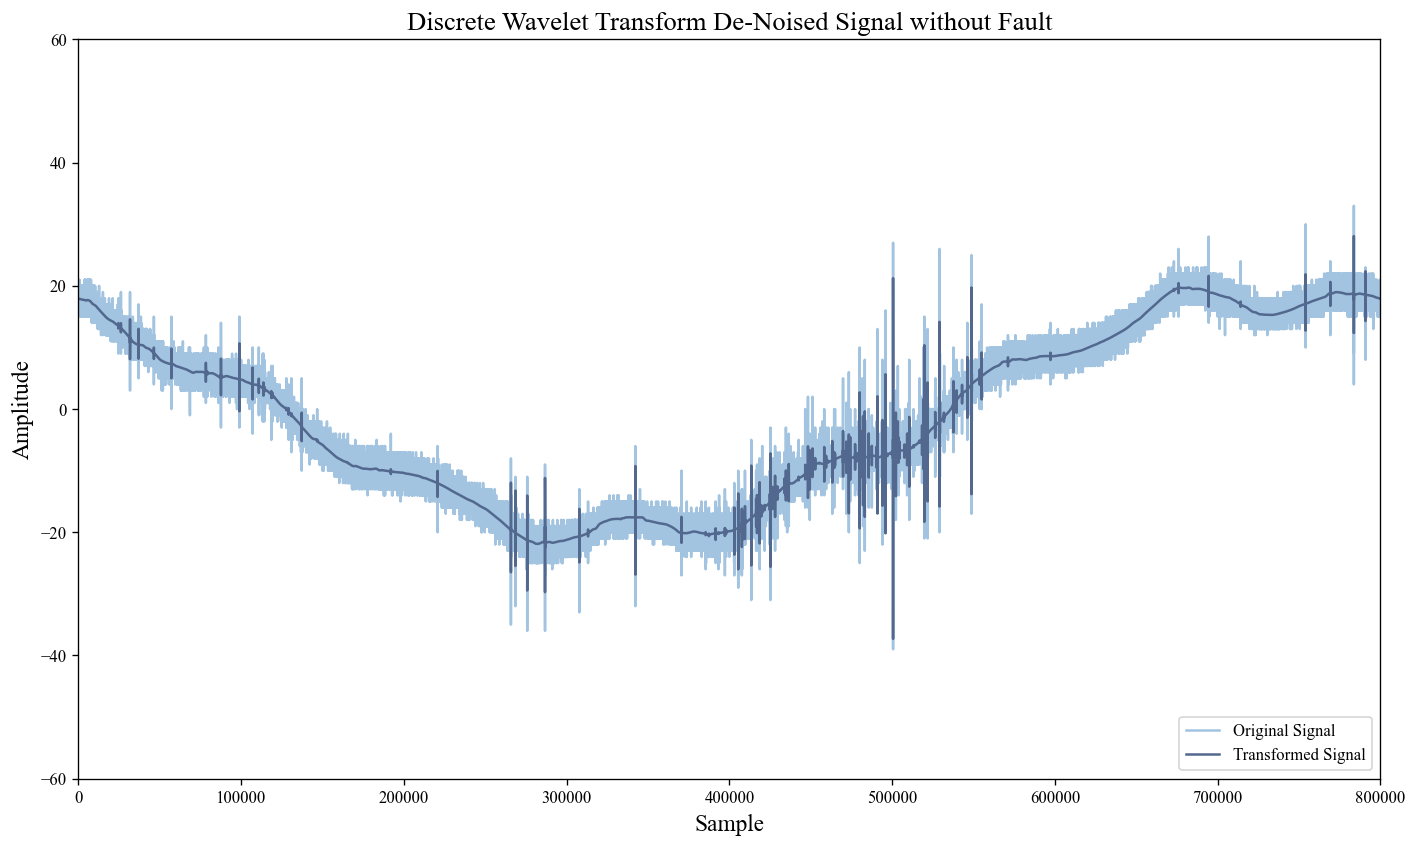

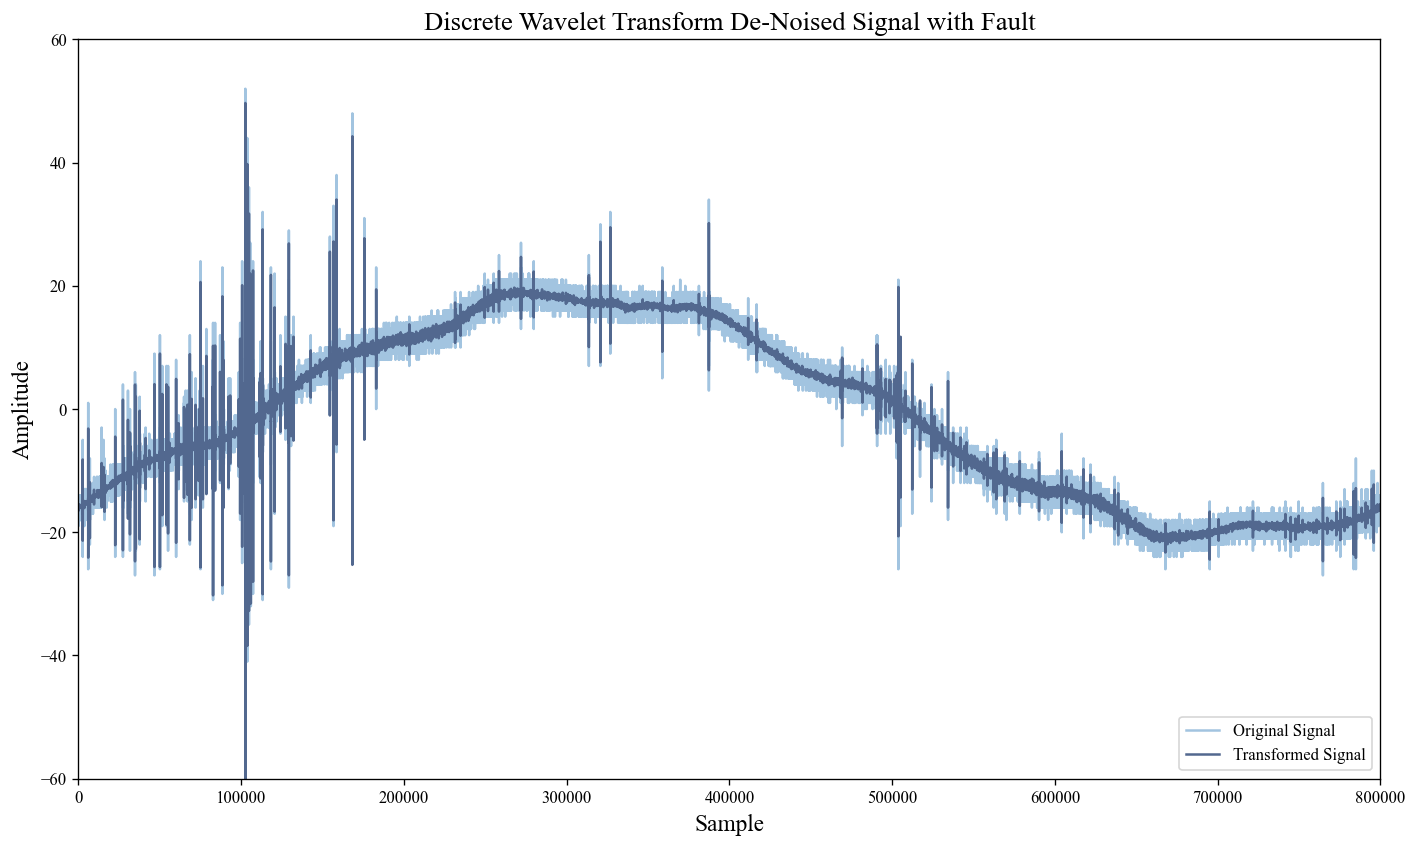

In [5]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot( x, color=colors[0], label="Original Signal")
    plt.plot( y, color=colors[2], label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample',fontsize=14)
    plt.ylabel('Amplitude',fontsize=14)
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title,fontsize=16)
    ax.set_xlim((0,len(y)))
    plt.show()
    return y
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmooth(df["0"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmooth(df["3"], wavelet="db4", level=1, title=title1 )

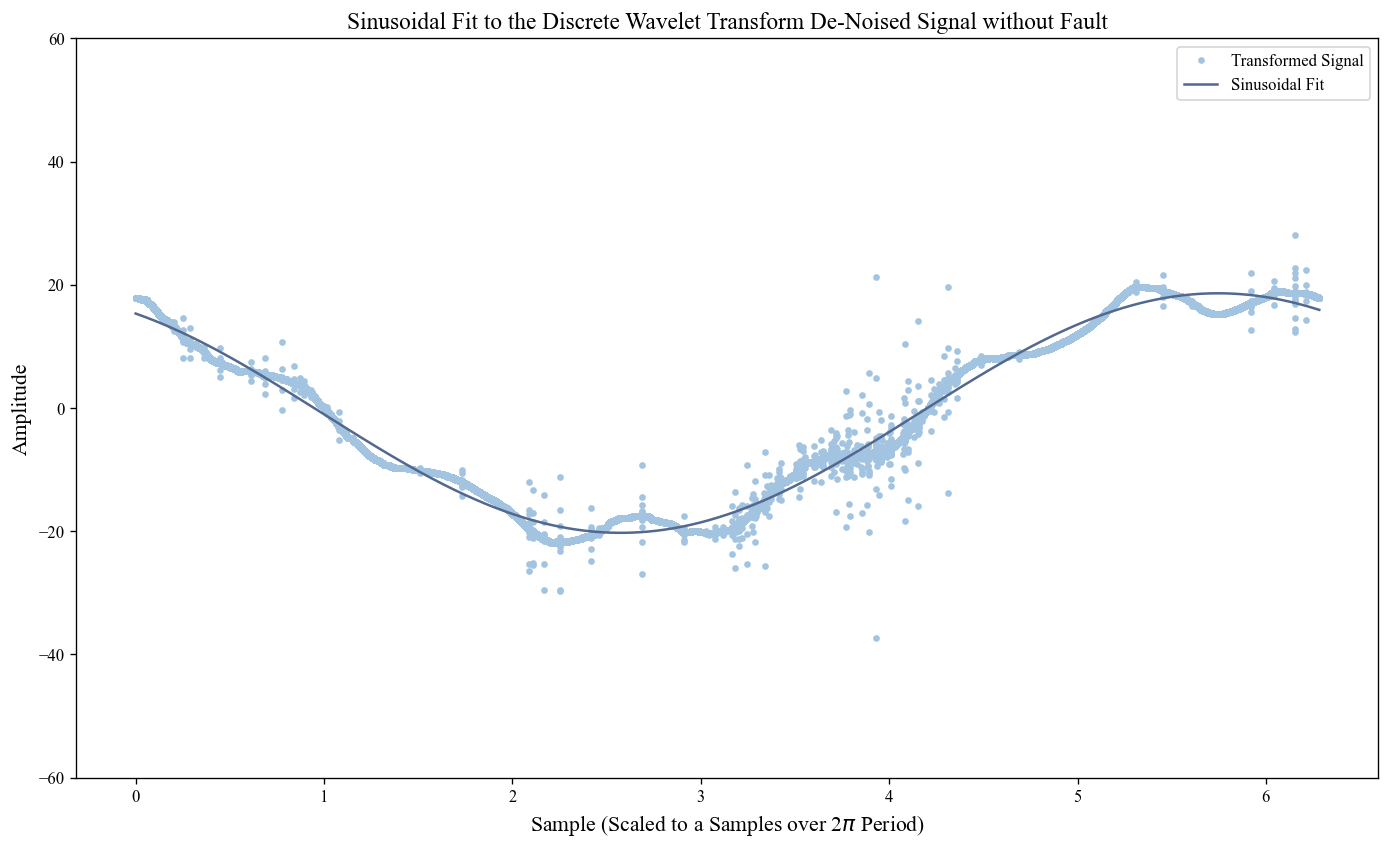

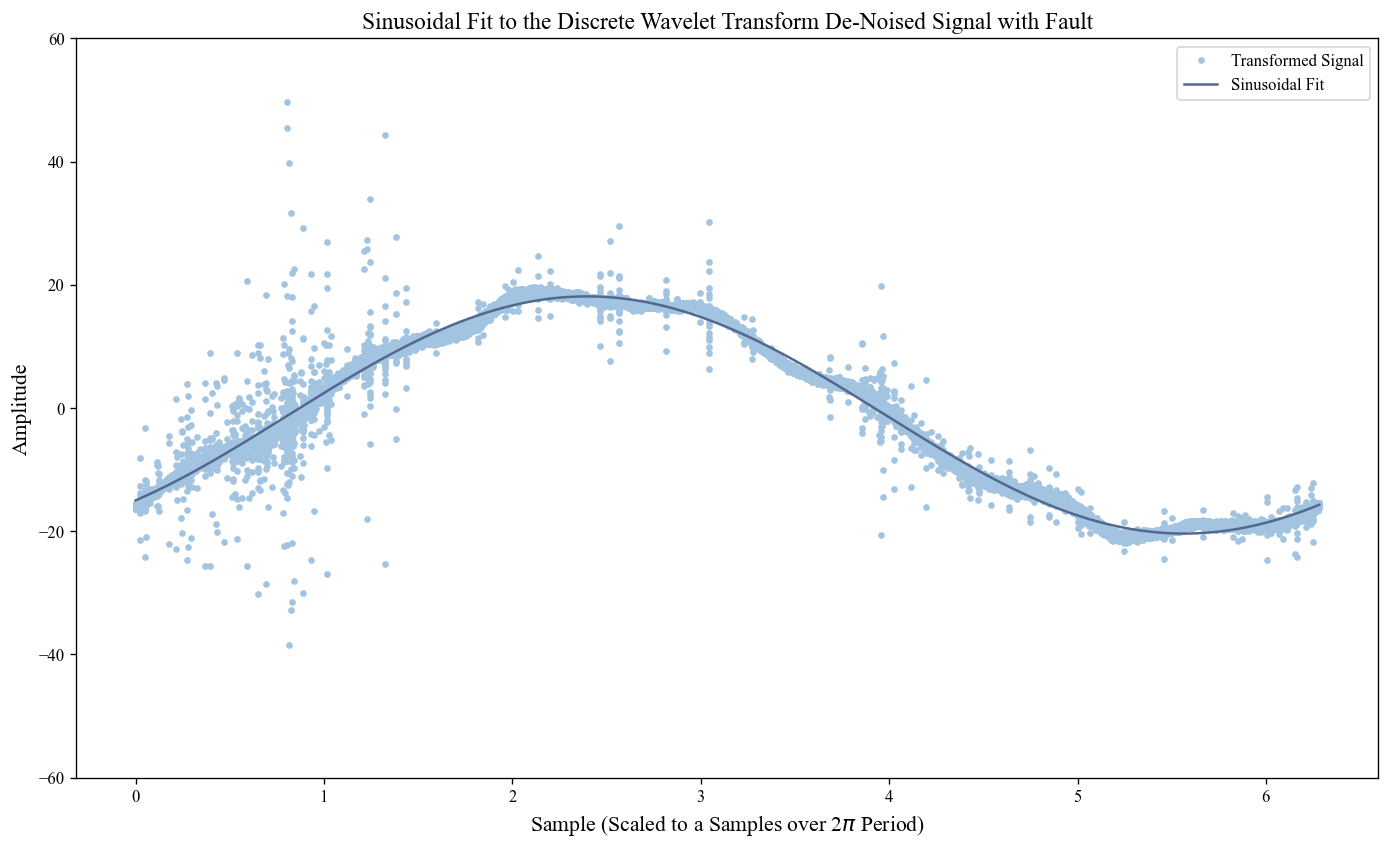

In [6]:
from scipy.optimize import leastsq

def fit_sinusoid(signal, title):
    t = np.linspace(0, 2*np.pi, len(signal))  # data covers one period
    guess_mean = np.mean(signal)
    guess_std = 3*np.std(signal)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 20

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - signal
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    signal_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(t, signal, '.', color=colors[0], label="Transformed Signal")
    plt.plot(t, signal_fit,  color=colors[2], label="Sinusoidal Fit",)
    plt.xlabel(r"Sample (Scaled to a Samples over 2$\pi$ Period)",fontsize=13)
    plt.ylabel("Amplitude",fontsize=13)
    plt.ylim((-60, 60))
    plt.title(title,fontsize=14)
    plt.legend()
    
    plt.show()
    return signal_fit

title0 = "Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal without Fault"
title1 = "Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal with Fault"
signal_fit0 = fit_sinusoid(signal_0, title0)
signal_fit1 = fit_sinusoid(signal_1, title1)

In [8]:
def find_pd_probable(signal_fit, condition):
    first_derivative = np.gradient(signal_fit)
    return [i for i, elem in enumerate(first_derivative) if condition(elem)]

high_prob_region0 = find_pd_probable(signal_fit0, lambda e: e>0)
high_prob_region1 = find_pd_probable(signal_fit1, lambda e: e>0)

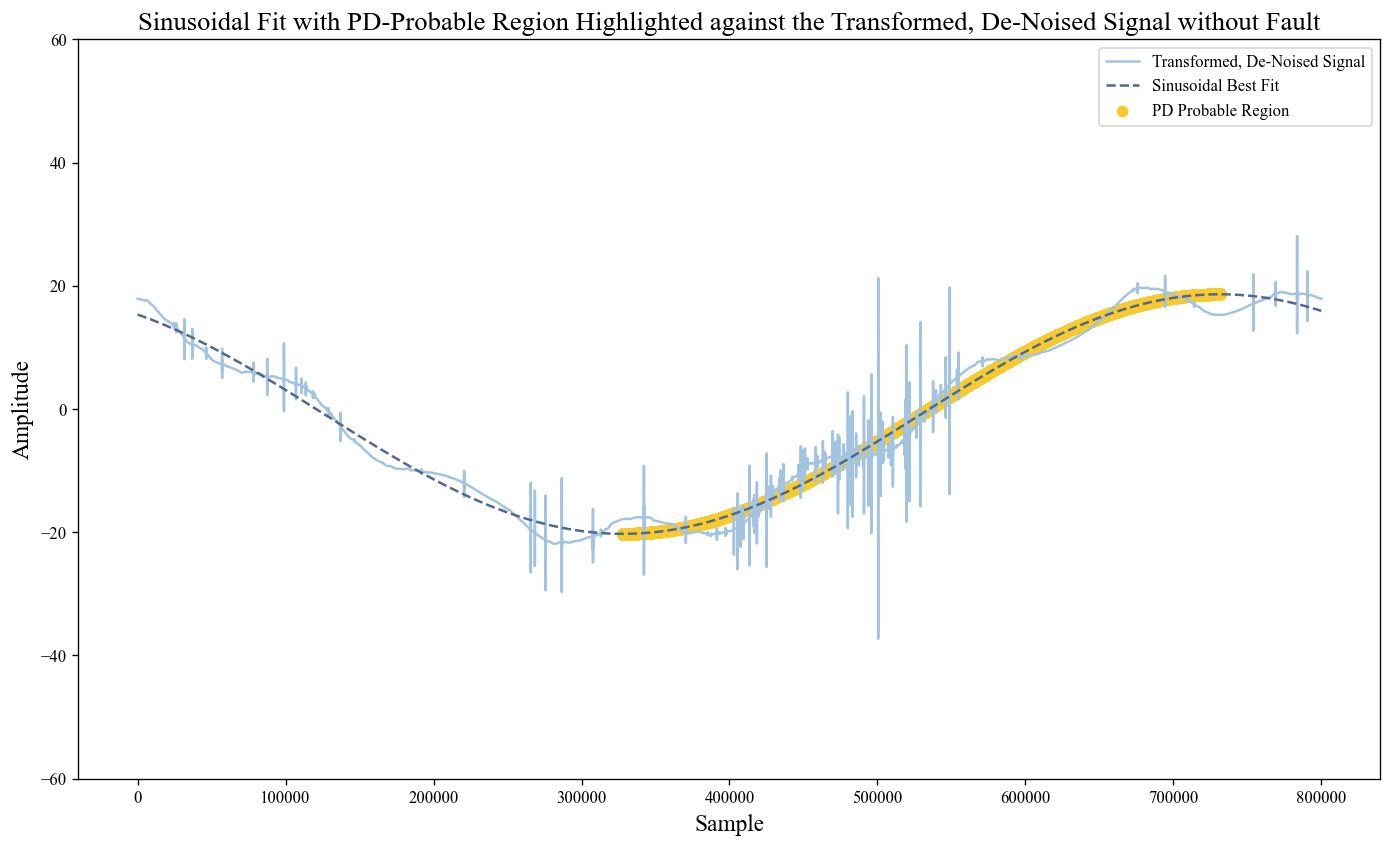

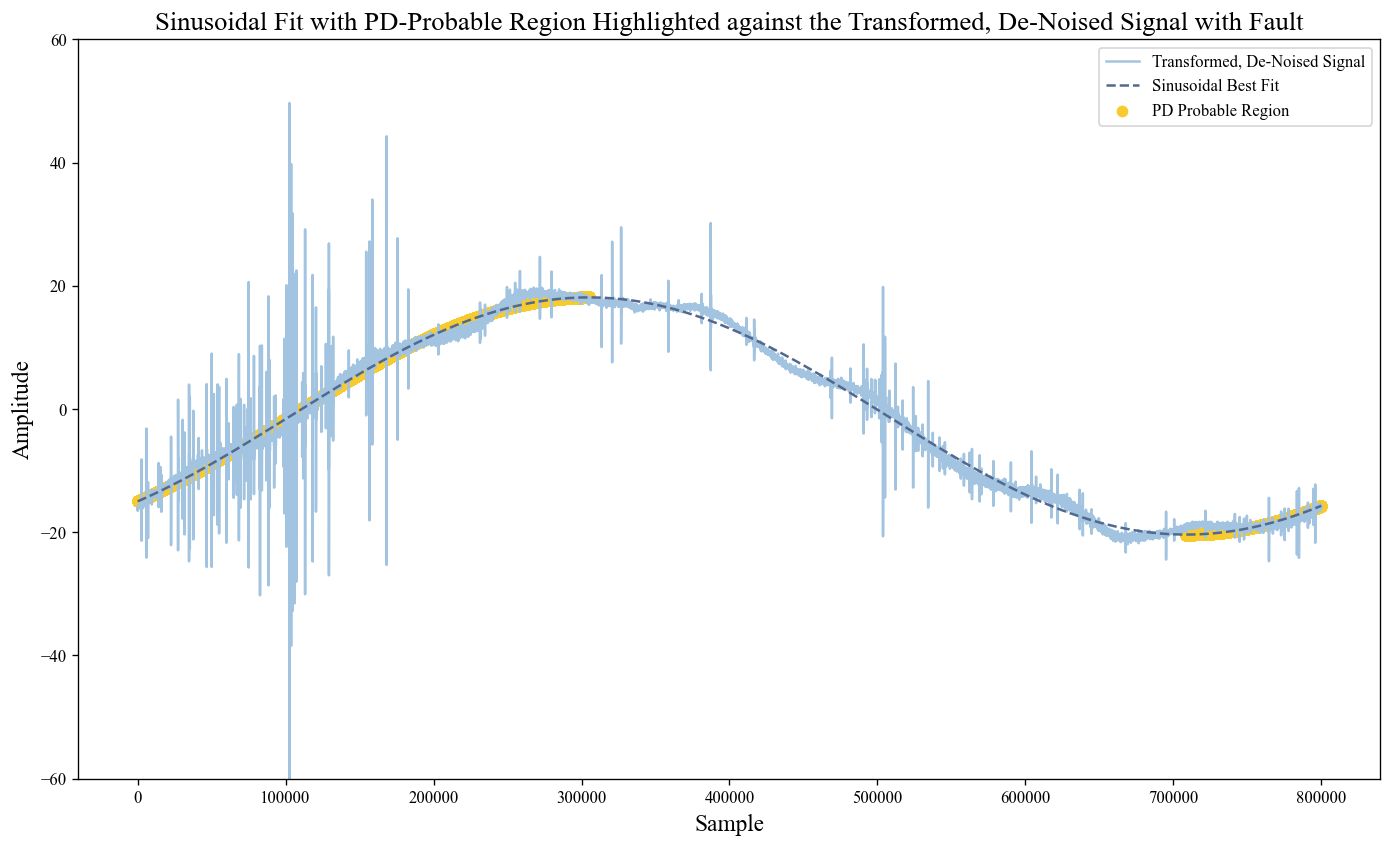

In [9]:
def plot_pd_probable(signal, signal_fit, high_prob_region, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(signal, color=colors[0], label="Transformed, De-Noised Signal")
    plt.plot(signal_fit, '--', color=colors[2], label="Sinusoidal Best Fit")
    plt.scatter(high_prob_region, signal_fit[high_prob_region], color=colors[3], label="PD Probable Region")
    plt.legend()
    plt.ylim((-60, 60))
    plt.ylabel("Amplitude",fontsize=14)
    plt.xlabel("Sample",fontsize=14)
    plt.title(title,fontsize=16)
    return

title0 = "Sinusoidal Fit with PD-Probable Region Highlighted against the Transformed, De-Noised Signal without Fault"
title1 = "Sinusoidal Fit with PD-Probable Region Highlighted against the Transformed, De-Noised Signal with Fault"
plot_pd_probable(signal_0, signal_fit0, high_prob_region0, title0)
plot_pd_probable(signal_1, signal_fit1, high_prob_region1, title1)

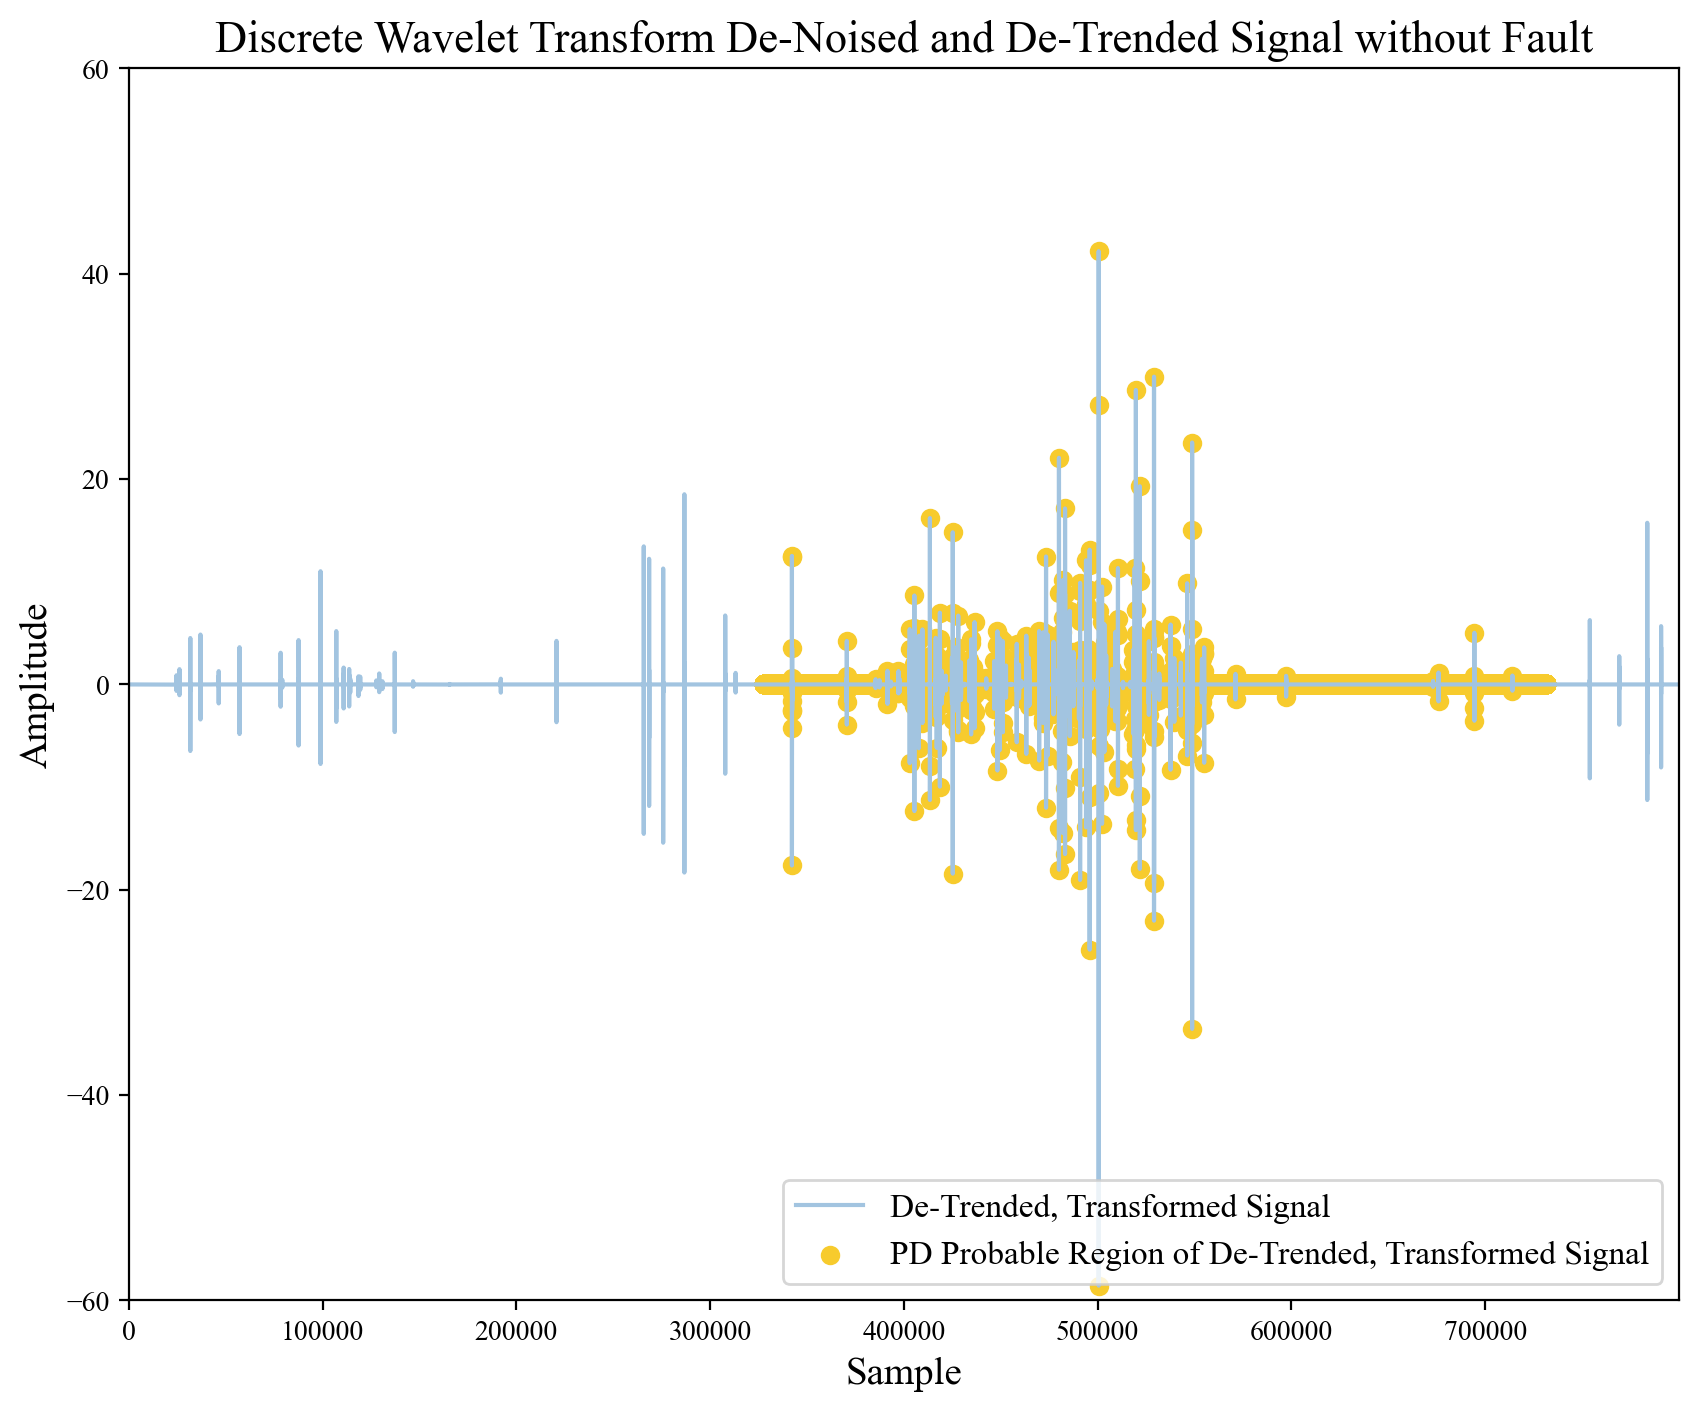

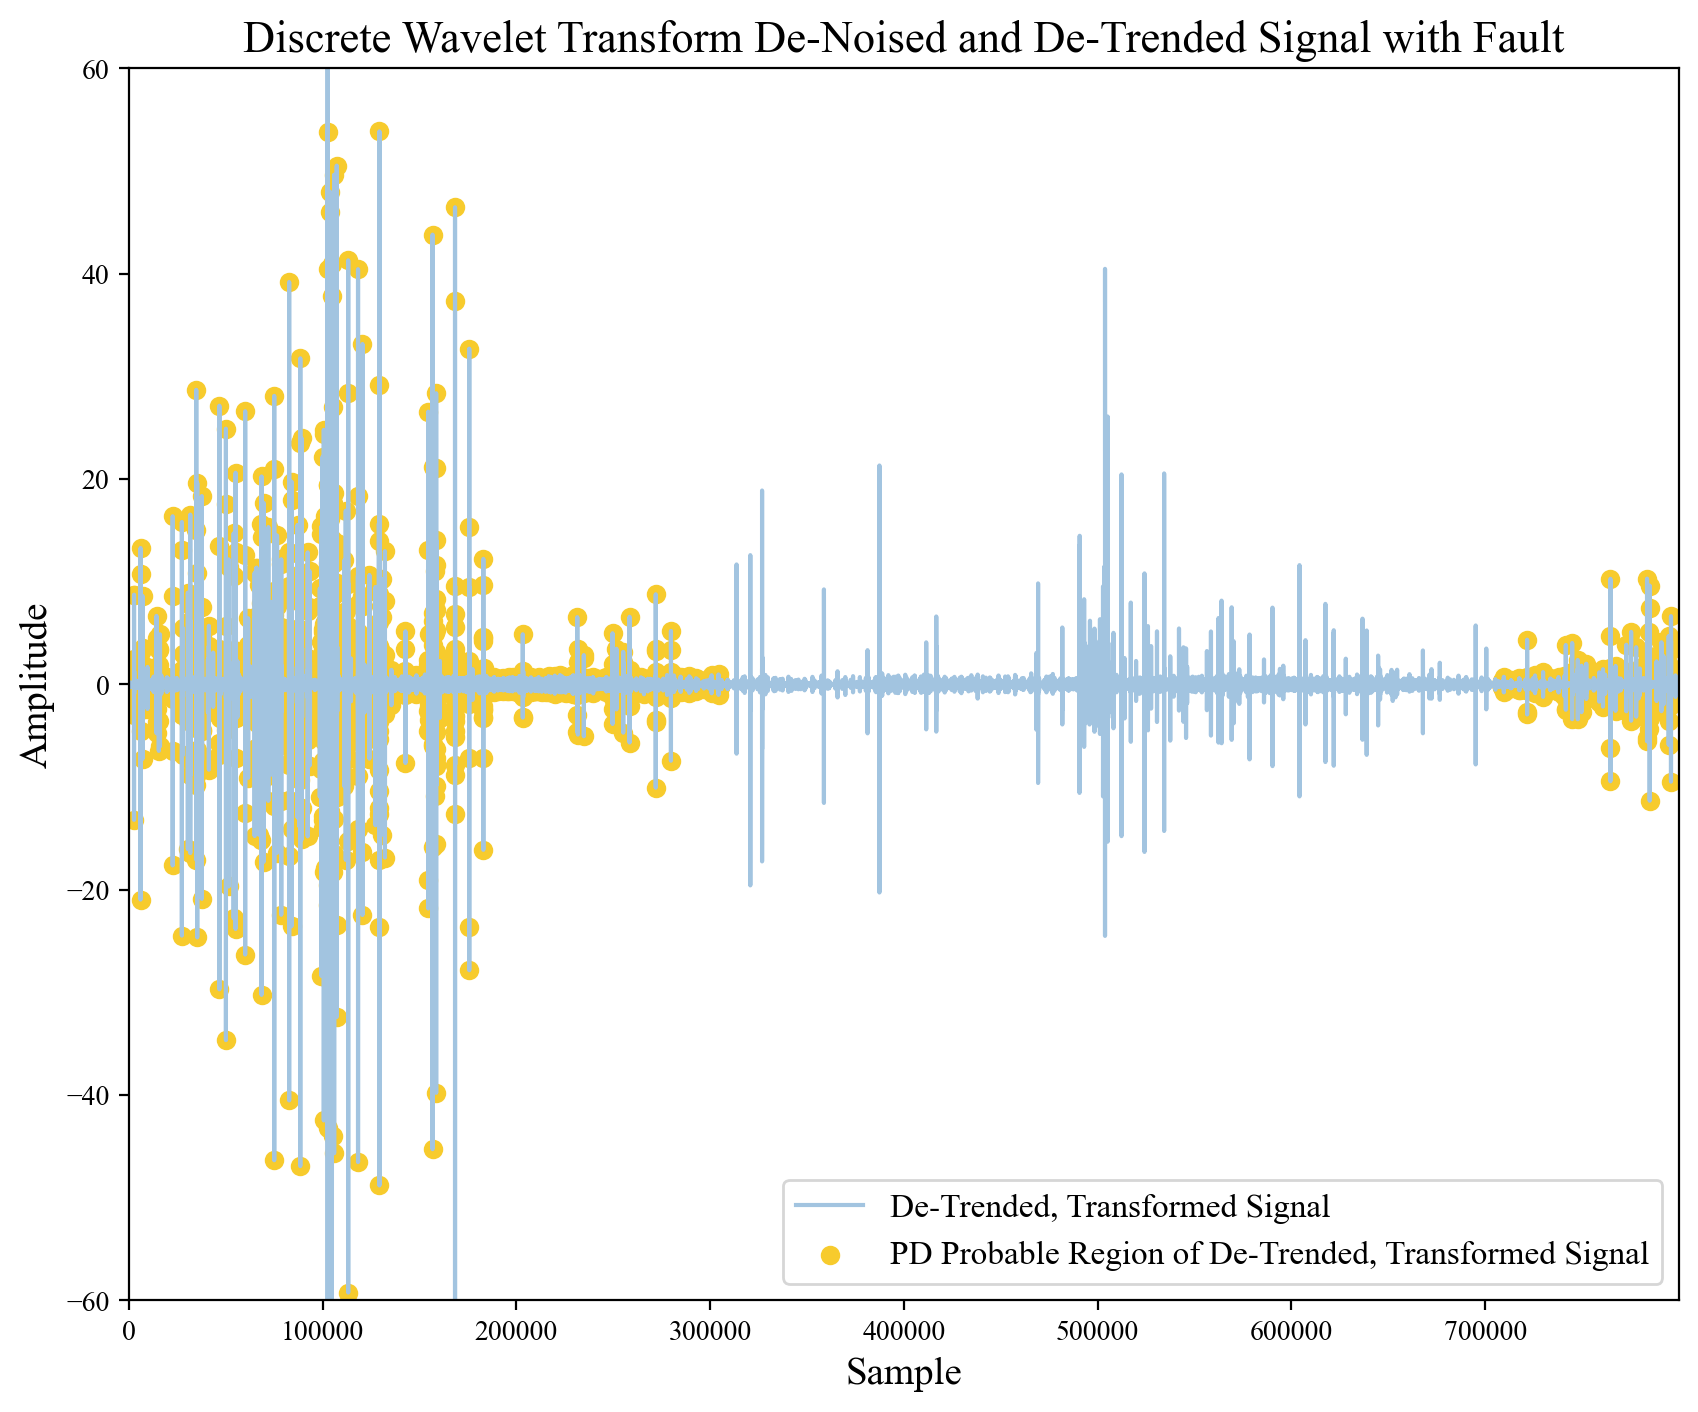

In [13]:
def detrend_signal( signal, high_prob_idx, title=None ):
    
    x = np.diff(signal, n=1)
    if max(high_prob_idx) == len(x):
        high_prob_idx = high_prob_idx[0:-1]
        
    f, ax = plt.subplots(figsize=(10, 8), dpi= 200, facecolor='w', edgecolor='k')
    plt.plot( x, color=colors[0], label="De-Trended, Transformed Signal")
    plt.scatter(high_prob_idx, x[high_prob_idx], color=colors[3], label="PD Probable Region of De-Trended, Transformed Signal" )
    plt.xlim((-100,100))
    plt.ylim((-60, 60))
    plt.xlabel('Sample',fontsize=14)
    plt.ylabel('Amplitude',fontsize=14)
    plt.legend(loc='lower right',fontsize=12)
    if title:
        ax.set_title(title,fontsize=16)
    ax.set_xlim((0,len(x)))
    return x[high_prob_idx]

title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
signal_0hp =  detrend_signal(signal_0, high_prob_region0, title0)
signal_1hp =  detrend_signal(signal_1, high_prob_region1, title1)

In the above diagrams we see that under no fault condition the probability of finding a PD is among the signals from the samples 350000 to 720000 and the probability of finding the PD under fault in within the samples of 0-30000 and from 700000-800000

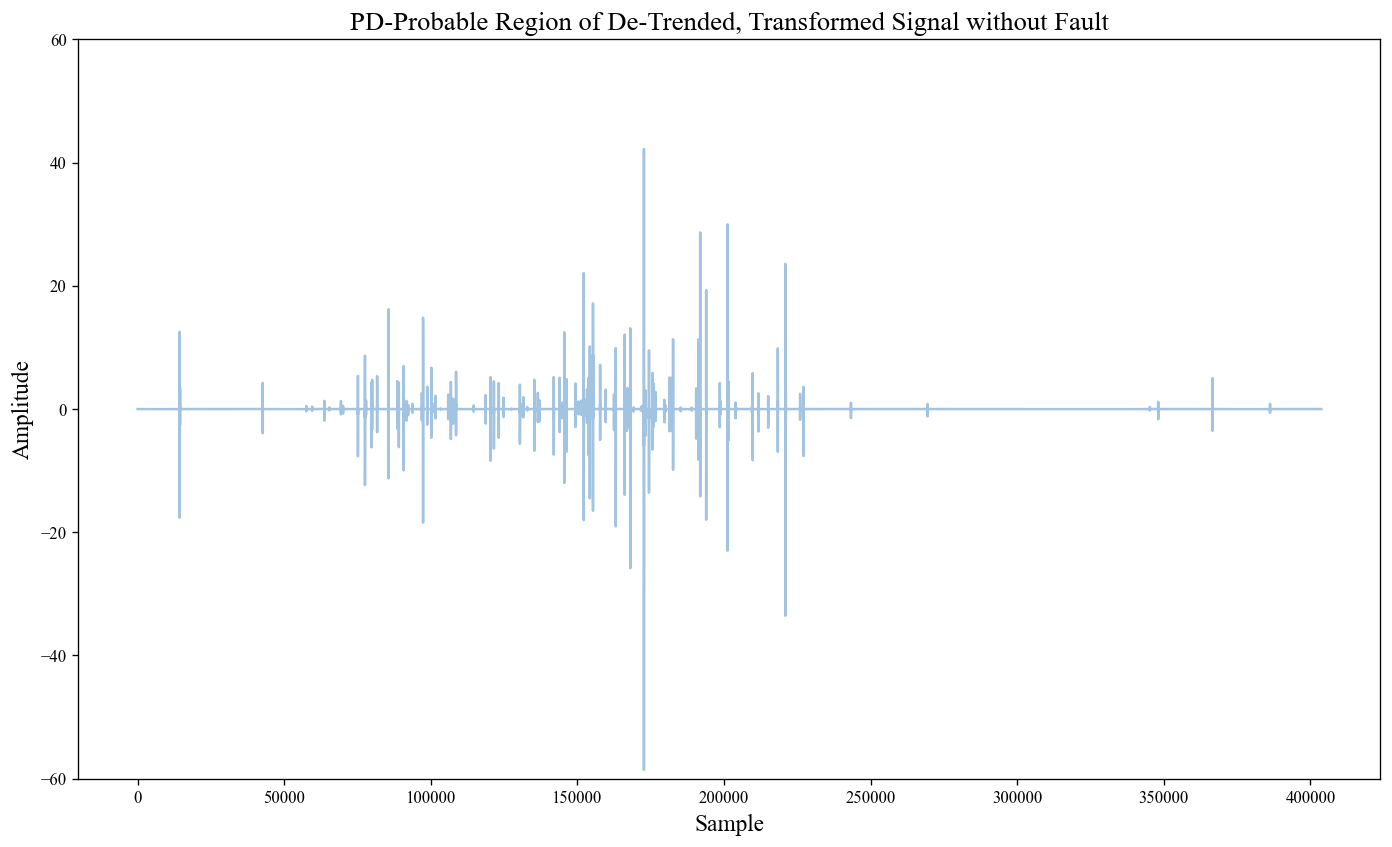

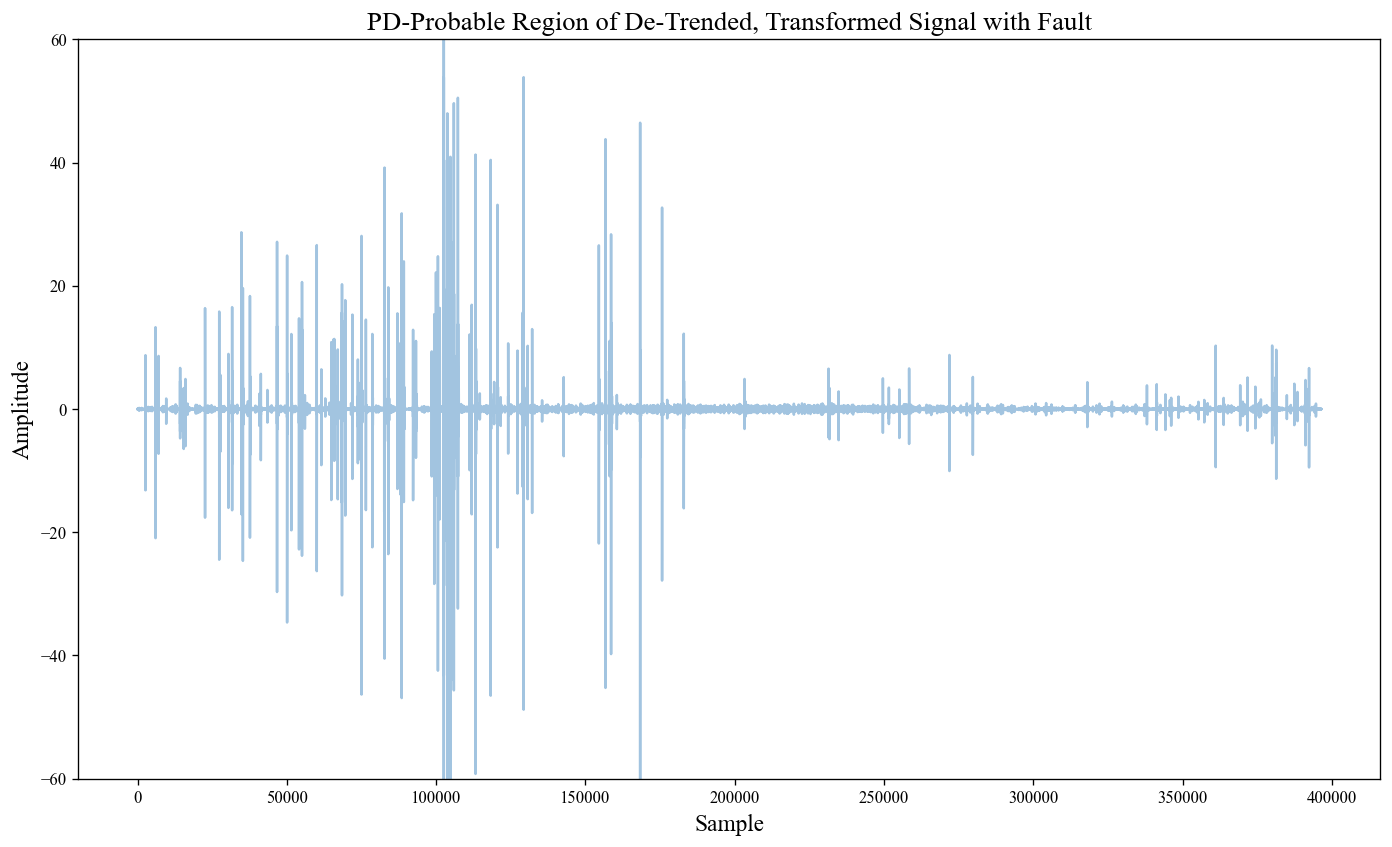

In [14]:
def plot_pd_prob_detrend(signal_hp, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(signal_hp, color=colors[0])
    plt.ylim((-60, 60))
    plt.xlabel("Sample",fontsize=14)
    plt.ylabel("Amplitude",fontsize=14)
    plt.title(title,fontsize=16)
    return

title0 = "PD-Probable Region of De-Trended, Transformed Signal without Fault"
title1 = "PD-Probable Region of De-Trended, Transformed Signal with Fault"
plot_pd_prob_detrend(signal_0hp, title0)
plot_pd_prob_detrend(signal_1hp, title1)

## Finding the Peaks

In [15]:
%pip install peakutils

Note: you may need to restart the kernel to use updated packages.


139
478


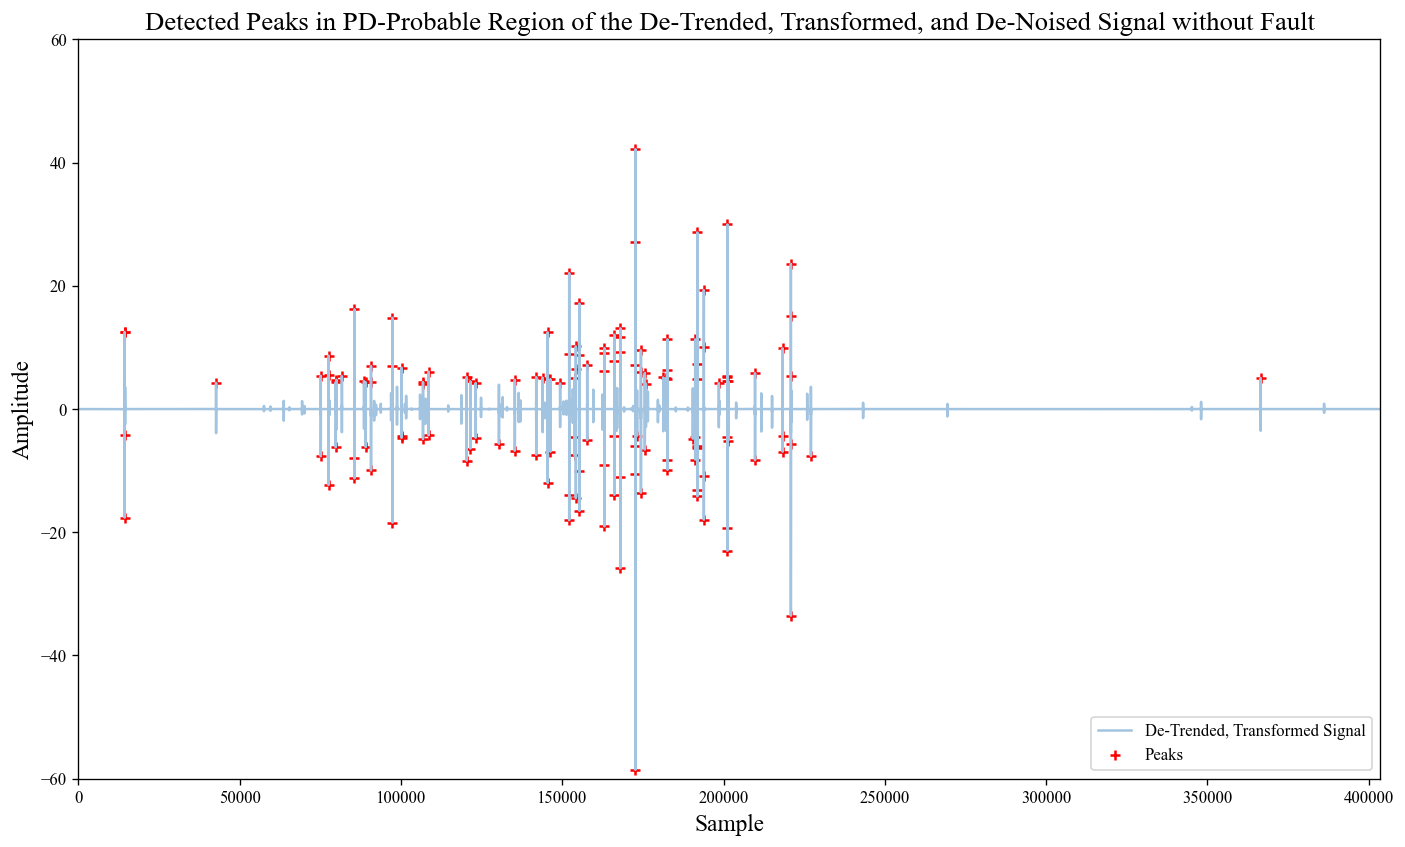

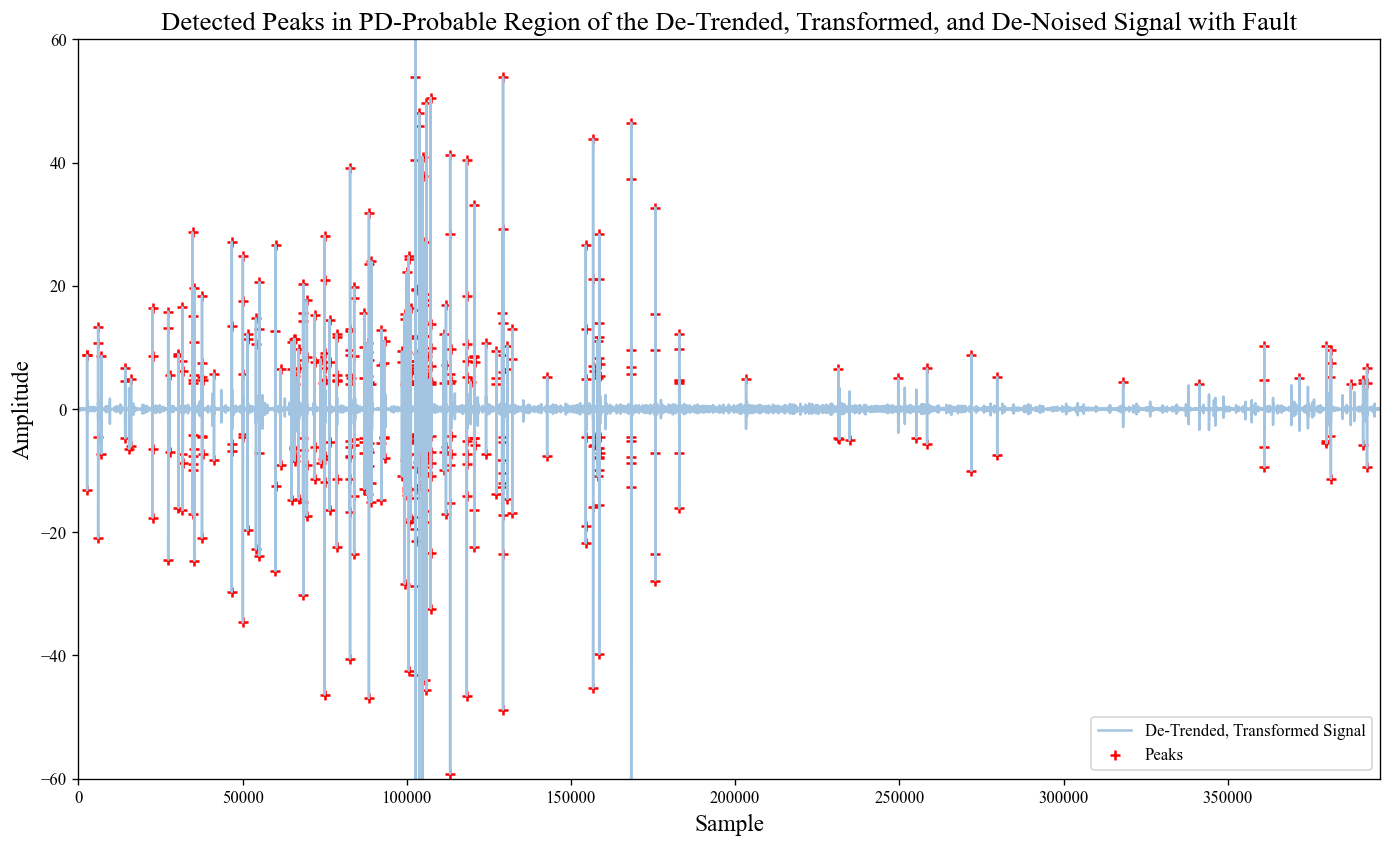

In [16]:
import peakutils

def find_peaks(signal, title):
    thresh = 0.6  # used for peakutils
    thresh = 4.0  # used for fixed amplitude
    min_d = 0

    #peaks = peakutils.indexes(1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    peaks = np.argwhere(signal > thresh)
    #valleys = peakutils.indexes(-1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    valleys = np.array(np.argwhere(signal < -thresh))
    pois = np.sort(np.concatenate((peaks, valleys)))
    
    peak_indexes = []
    for pk in pois:
        #peak_indexes.append(pk)
        peak_indexes.append(pk[0])

    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    #plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    plt.plot( signal, color=colors[0], label="De-Trended, Transformed Signal" )
    plt.scatter(peak_indexes, signal[peak_indexes], marker="+", color="red", label="Peaks" )
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((102500, 102600))
    plt.xlabel('Sample',fontsize=14)
    plt.ylabel('Amplitude',fontsize=14)
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title,fontsize=16)
    ax.set_xlim((0,len(signal)))
    print(len(peak_indexes))
    return np.sort(peak_indexes)

title0 = 'Detected Peaks in PD-Probable Region of the De-Trended, Transformed, and De-Noised Signal without Fault'
title1 = 'Detected Peaks in PD-Probable Region of the De-Trended, Transformed, and De-Noised Signal with Fault'
peak_indexes0 = find_peaks(signal_0hp, title=title0 )
peak_indexes1 = find_peaks(signal_1hp, title=title1 )

In [17]:
def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 20  # 
    max_height_ratio = 0.75  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])

            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

false_peak_indexes0 = cancel_false_peaks(signal_0hp, peak_indexes0)
false_peak_indexes1 = cancel_false_peaks(signal_1hp, peak_indexes1)

In [18]:
def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    thresh = 30.0
    #peaks = peakutils.indexes(1.0*(signal), thres=0.80, min_dist=0)
    peaks = np.argwhere(signal > thresh)
    #valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0) 
    valleys = np.argwhere(signal < -thresh)
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx in false_peak_indexes:
            false_peak_indexes.append(pk_idx[0])
    return np.sort(false_peak_indexes)

false_peak_indexes0 = cancel_high_amp_peaks(signal_0hp, peak_indexes0, false_peak_indexes0)
false_peak_indexes1 = cancel_high_amp_peaks(signal_1hp, peak_indexes1, false_peak_indexes1)

In [19]:
# Calcel Peaks Flagged as False, Find True Preaks
def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = set(peak_indexes) - set(false_peak_indexes)
    return np.sort(list(true_peak_indexes))

true_peak_indexes0 = cancel_flagged_peaks(peak_indexes0, false_peak_indexes0)
true_peak_indexes1 = cancel_flagged_peaks(peak_indexes1, false_peak_indexes1)

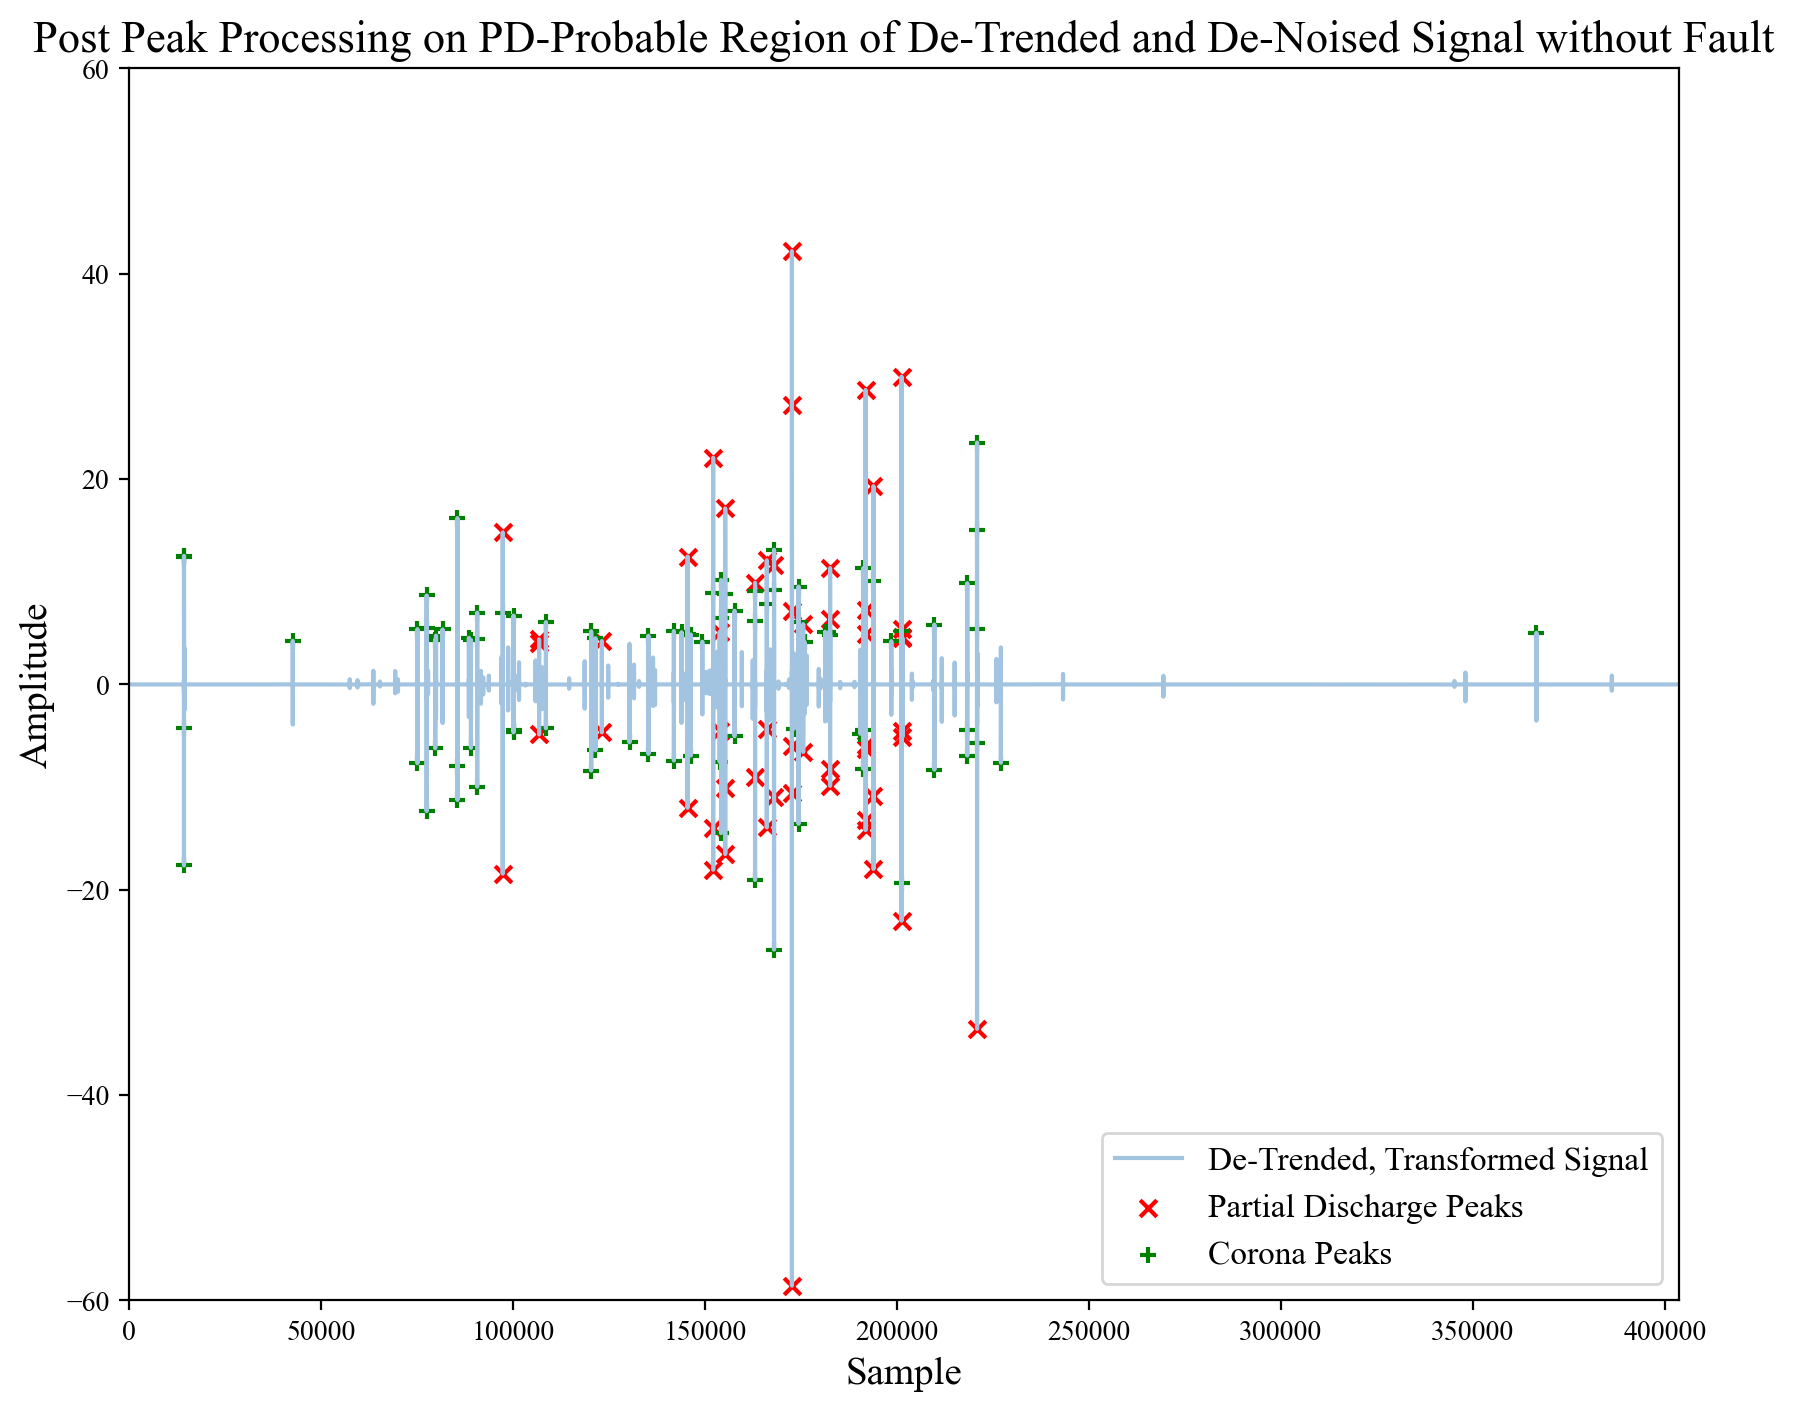

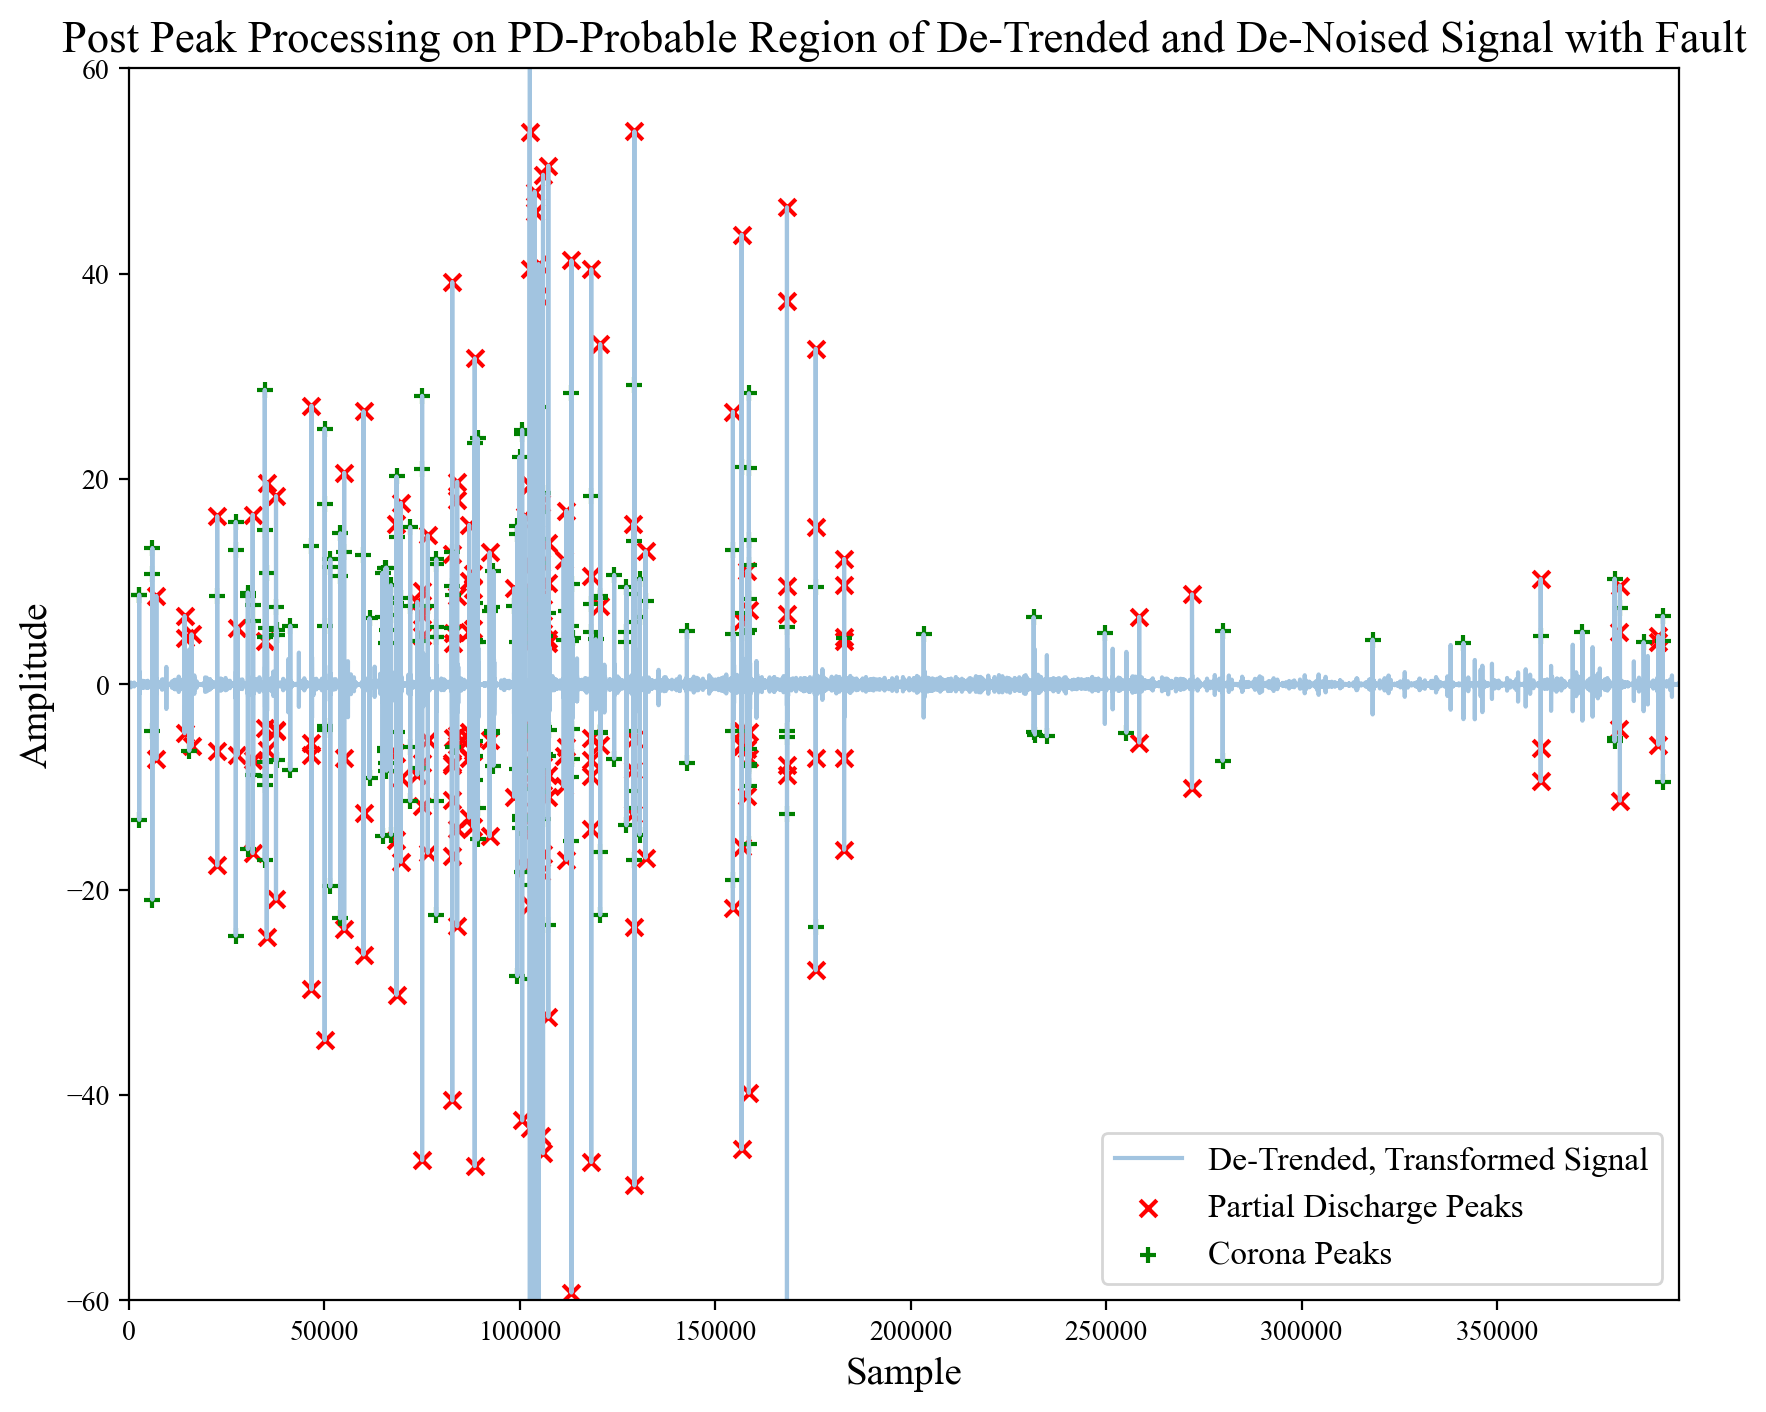

In [20]:
def plot_peaks(signal, true_peak_indexes, false_peak_indexes, title):
    f, ax = plt.subplots(figsize=(10, 8), dpi= 200, facecolor='w', edgecolor='k')
    plt.plot( signal, color=colors[0], label="De-Trended, Transformed Signal" )  #5 alt color 1ACC5
    plt.scatter(false_peak_indexes, signal[false_peak_indexes], marker="x", color="red", label="Partial Discharge Peaks")
    plt.scatter(true_peak_indexes, signal[true_peak_indexes], marker="+", color="green", label="Corona Peaks")
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((102500, 102600))
    plt.xlabel('Sample',fontsize=14)
    plt.ylabel('Amplitude',fontsize=14)
    plt.legend(loc='lower right',fontsize=12)
    if title:
        ax.set_title(title,fontsize=16)
    ax.set_xlim((0,len(signal)))
    plt.show()
    return

title0 = 'Post Peak Processing on PD-Probable Region of De-Trended and De-Noised Signal without Fault'
title1 = 'Post Peak Processing on PD-Probable Region of De-Trended and De-Noised Signal with Fault'
plot_peaks(signal_0hp, true_peak_indexes0, false_peak_indexes0, title0)
plot_peaks(signal_1hp, true_peak_indexes1, false_peak_indexes1, title1)

From the above diagram we distinguish the Corona peaks (True Peaks) from the PD peaks (Cancelled peaks)

In [18]:
import scipy
from statsmodels.robust import mad
import collections

#  Feature Extraction Functions
def calculate_entropy(signal):
    counter_values = collections.Counter(signal).most_common()
    probabilities = [elem[1]/len(signal) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(signal):
    n5 = np.nanpercentile(signal, 5)
    n25 = np.nanpercentile(signal, 25)
    n75 = np.nanpercentile(signal, 75)
    n95 = np.nanpercentile(signal, 95)
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(signal) > np.nanmean(signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def find_all_peaks(signal, threshold=0.7, min_distance=0):
    #peaks = peakutils.indexes(1.0*(signal), thres=threshold, min_dist=min_distance)
    peaks = np.argwhere(signal > 1.0*threshold)
    #valleys = peakutils.indexes(-1.0*(signal), thres=threshold, min_dist=min_distance)
    valleys = np.array(np.argwhere(signal < -1.0*threshold))
    pois = np.sort(np.concatenate((peaks, valleys)))
    peak_indexes = []
    for pk in pois:
        #peak_indexes.append(pk)
        peak_indexes.append(pk[0])
    return np.sort(peak_indexes), peaks, valleys
def calculate_peak_widths(peak_idxs):
    tmp_w = 1
    widths = []
    for idx in range(1,len(peak_idxs)):
        if peak_idxs[idx]-peak_idxs[idx-1] < 3:
            tmp_w +=1
        else:
            widths.append(tmp_w)
            tmp_w = 1
    widths.append(tmp_w)
    min_width = min(np.array(widths))
    max_width = max(np.array(widths))
    mean_width = np.nanmean(np.array(widths))
    num_true_peaks = len(widths)
    return min_width, max_width, mean_width, num_true_peaks

def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 500  # 
    max_height_ratio = 0.25  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:  # opposite polarity and within symmetric check distance
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:  # ratio of opposing polarity check
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)  # build pulse train
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes
def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    threshold = 50  # amplitude threshld for determining high amplitude peaks for cancellation
    #peaks = peakutils.indexes(1.0*(signal), thres=0.80, min_dist=0)
    peaks = np.argwhere(signal > 1.0*threshold)
    #valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0)
    valleys = np.argwhere(signal < -1.0*threshold)
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx[0] in false_peak_indexes:
            false_peak_indexes.append(pk_idx[0])
    return false_peak_indexes

def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = list(set(peak_indexes) - set(false_peak_indexes))
    true_peak_indexes.sort()
    return true_peak_indexes

def low_high_peaks(signal, true_peak_indexes, hi_idx, lo_idx):
    if np.size(np.array(hi_idx))> 0:
        lhr = 1.0*np.size(np.array(lo_idx))/np.size(np.array(hi_idx))
    else:
        lhr = 0.0
    hi_true = 0
    lo_true = 0
    for x in true_peak_indexes:
        if signal[x] > 0.0:
            hi_true += 1
        else:
            lo_true += 1
    if hi_true > 0:
        lhrt = 1.0*lo_true/hi_true
    else:
        lhrt = 0.0
    return [hi_idx, lo_idx, lhr, hi_true, lo_true, lhrt]
def calculate_peaks(signal, true_peak_indexes):  # Peak Characteristics on True Peaks
    peak_values = signal[true_peak_indexes]
    num_detect_peak = len(true_peak_indexes)
    if num_detect_peak > 0:
        min_height = min(peak_values)
        max_height = max(peak_values)
        mean_height = np.nanmean(peak_values)
        min_width, max_width, mean_width, num_true_peaks = calculate_peak_widths(true_peak_indexes)
        return [min_height, max_height, mean_height, min_width, max_width, mean_width, num_detect_peak, num_true_peaks]
    else:
        return [0, 0, 0, 0, 0, 0, 0, 0]

def get_features(signal, signal_id, threshold, min_distance): # Extract features from the signal and build an array of them
    peak_indexes, hi_idx, lo_idx = find_all_peaks(signal, threshold, min_distance)
    #print("Now processing signal_id: "+str(signal_id)+" with peak detection threshold at "+str(threshold)+" yielding "+str(len(peak_indexes))+" peaks at "+datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    false_peak_indexes = cancel_false_peaks(signal, peak_indexes)
    false_peak_indexes = cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes)
    #false_peak_indexes = []  # Don't cancel peaks
    true_peak_indexes = cancel_flagged_peaks(peak_indexes, false_peak_indexes)

    entropy = calculate_entropy(signal)
    statistics = calculate_statistics(signal)
    crossings = calculate_crossings(signal)
    peaks = calculate_peaks(signal, true_peak_indexes)
    low_high_stats = low_high_peaks(signal, true_peak_indexes, hi_idx, lo_idx)
    return [entropy] + statistics + crossings + peaks + low_high_stats

threshold = 0.45  # Threshold for db_bit fixed threshold, not peak_detector package
min_distance = 0  # Minimum distance in samples between detected peaks

signal_id = 0  # in this example use signal_id = 0
data_type = "train"  # signal_id 0 belongs to the training set, not the test set in this example
signal_features = get_features(signal_0hp, signal_id, threshold, min_distance)

# Machine Learning Models 

## Classification Models

In [19]:
df1=pd.read_csv(r"D:\DataSets\Partial Discharge Dataset-20230605T040721Z-003\Partial Discharge Dataset\Partial Discharge Classification.csv")
df1

,signal_id,id_measurement,phase,target
0,8712,2904,0,0
1,8713,2904,1,0
2,8714,2904,2,0
3,8715,2905,0,1
4,8716,2905,1,1
...,...,...,...,...
8707,17419,5806,1,0
8708,17420,5806,2,0
8709,17421,5807,0,0
8710,17422,5807,1,0


In [20]:
X = df1.drop(['target'],axis=1)
y = df1['target']

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.10,random_state=10)

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [23]:
%pip install scikit-learn==0.24.2


  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [54 lines of output]
      <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      <string>:116: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
      INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      Traceback (most recent call last):
        File "c:\Users\Irfan\anaconda3\li

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=56)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Training Accuracy: 100.0 %
Model Accuracy Score: 89.38 %
Mathews Coefficient Of Correlation: -0.018181363234442735
--------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      3259
           1       0.04      0.03      0.04       226

    accuracy                           0.89      3485
   macro avg       0.49      0.49      0.49      3485
weighted avg       0.88      0.89      0.88      3485

--------------------------------------------------------


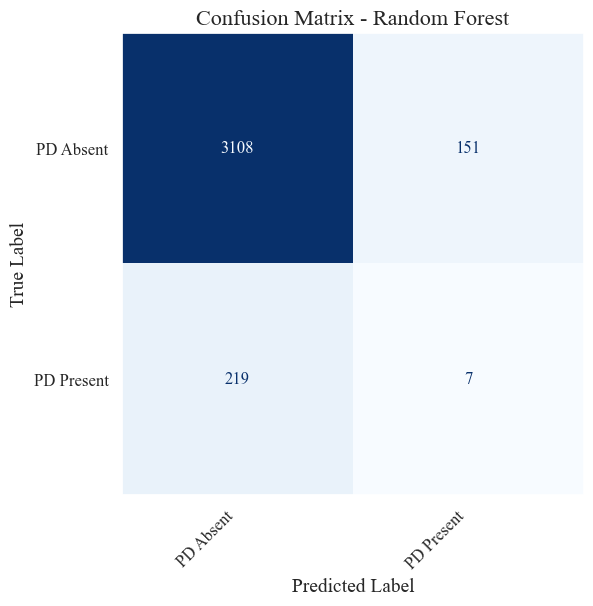

In [58]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Times New Roman'
# Create and fit the random forest classifier
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest.predict(X_test)

# Calculate metrics
random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_accuracy = round(accuracy_score(y_pred_rf, y_test) * 100, 2)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

# Print metrics
print("Training Accuracy:", random_forest_train, "%")
print("Model Accuracy Score:", random_forest_accuracy, "%")
print("Mathews Coefficient Of Correlation:", mcc_rf)
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\033[1m--------------------------------------------------------\033[0m")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PD Absent', 'PD Present'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues',colorbar=False)
sns.set(font_scale=1)
# Set background color and grid visibility
ax.set_facecolor('white')
ax.grid(False)

# Set tick labels without cutting off text
tick_labels = ['PD Absent', 'PD Present']
disp.ax_.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
disp.ax_.set_yticklabels(tick_labels,fontsize=12)

# Set axis labels and title
plt.title('Confusion Matrix - Random Forest',fontsize=16)
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('True Label',fontsize=14)

plt.show()


In [45]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=42)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Training Accuracy    : 95.24 %
Model Accuracy Score : 92.77 %
Matthews Coefficient of Correlation: 0.06414675135052288
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      3259
           1       0.20      0.04      0.07       226

    accuracy                           0.93      3485
   macro avg       0.57      0.51      0.51      3485
weighted avg       0.89      0.93      0.90      3485

--------------------------------------------------------


Text(0, 0.5, 'True Label')

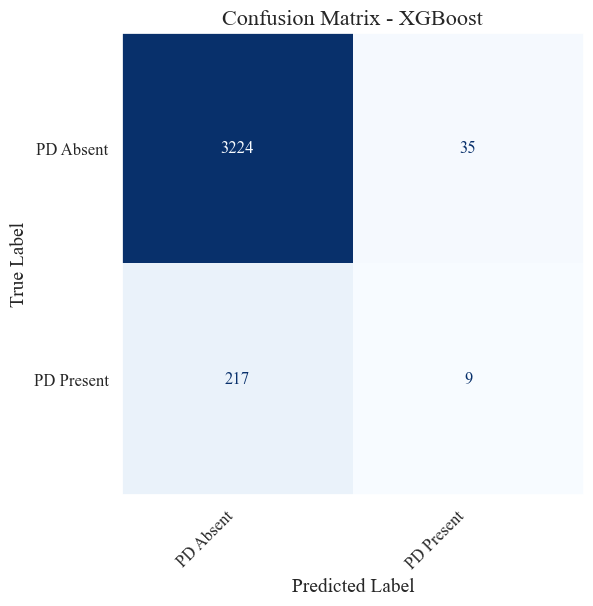

In [59]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
plt.rcParams['font.family']='Times New Roman'
# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_train = round(xgb.score(X_train, y_train) * 100, 2)
xgb_accuracy = round(accuracy_score(y_pred_xgb, y_test) * 100, 2)

# Calculate Matthews coefficient of correlation
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)

print("Training Accuracy    :", xgb_train, "%")
print("Model Accuracy Score :", xgb_accuracy, "%")
print("Matthews Coefficient of Correlation:", mcc_xgb)
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n", classification_report(y_test, y_pred_xgb))
print("\033[1m--------------------------------------------------------\033[0m")

# Plot confusion matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PD Absent', 'PD Present'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues',colorbar=False)
sns.set(font_scale=1)
# Set background color and grid visibility
ax.set_facecolor('white')
ax.grid(False)

# Set tick labels without cutting off text
tick_labels = ['PD Absent', 'PD Present']
disp.ax_.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
disp.ax_.set_yticklabels(tick_labels,fontsize=12)

# Set axis labels and title
plt.title('Confusion Matrix - XGBoost',fontsize=16)
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('True Label',fontsize=14)



In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


Training Accuracy    : 94.36 %
Model Accuracy Score : 93.34 %
Matthews Coefficient: 0.029440630245916866
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3259
           1       0.20      0.01      0.02       226

    accuracy                           0.93      3485
   macro avg       0.57      0.50      0.49      3485
weighted avg       0.89      0.93      0.90      3485

--------------------------------------------------------


Text(0, 0.5, 'True Label')

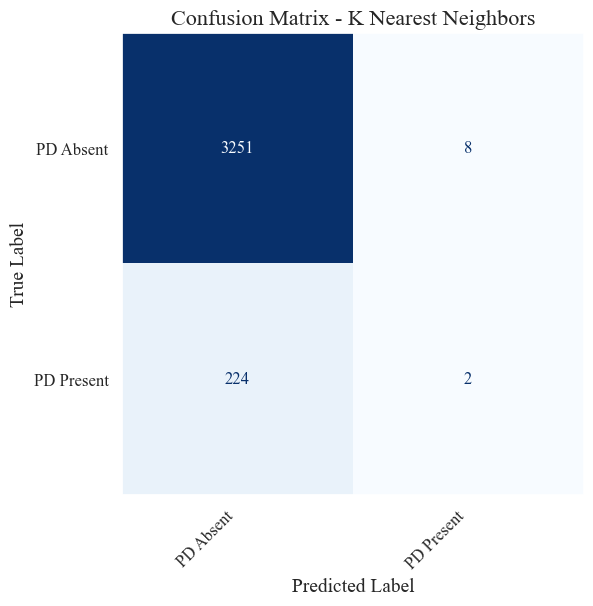

In [60]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
plt.rcParams['font.family']='Times New Roman'
# K Nearest Neighbors (KNN) Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_train = round(knn.score(X_train, y_train) * 100, 2)
knn_accuracy = round(accuracy_score(y_pred_knn, y_test) * 100, 2)

# Calculate Matthews coefficient of correlation
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)

print("Training Accuracy    :", knn_train, "%")
print("Model Accuracy Score :", knn_accuracy, "%")
print("Matthews Coefficient:", mcc_knn)
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n", classification_report(y_test, y_pred_knn))
print("\033[1m--------------------------------------------------------\033[0m")
cm = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PD Absent', 'PD Present'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues',colorbar=False)
sns.set(font_scale=1)
# Set background color and grid visibility
ax.set_facecolor('white')
ax.grid(False)

# Set tick labels without cutting off text
tick_labels = ['PD Absent', 'PD Present']
disp.ax_.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
disp.ax_.set_yticklabels(tick_labels,fontsize=12)

# Set axis labels and title
plt.title('Confusion Matrix - K Nearest Neighbors',fontsize=16)
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('True Label',fontsize=14)


In [34]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Training Accuracy    : 100.0 %
Model Accuracy Score : 95.04 %
Matthews Coefficient: 0.578059019744294
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      3259
           1       0.63      0.58      0.60       226

    accuracy                           0.95      3485
   macro avg       0.80      0.78      0.79      3485
weighted avg       0.95      0.95      0.95      3485

--------------------------------------------------------


Text(0, 0.5, 'True Label')

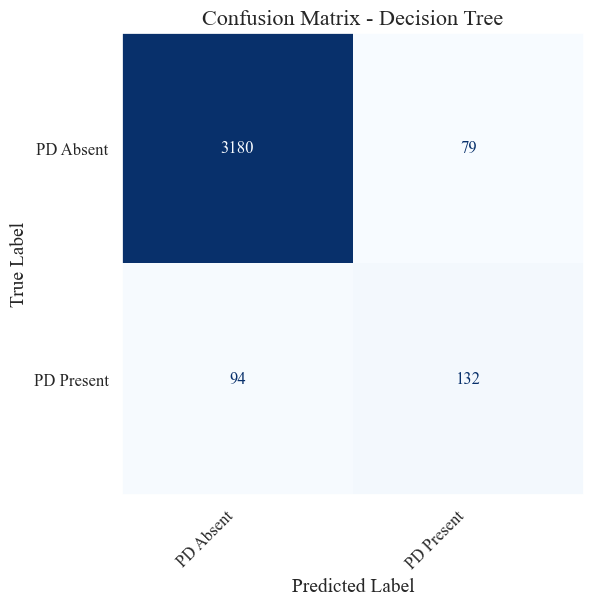

In [61]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
plt.rcParams['font.family']='Times New Roman'
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_train = round(dt.score(X_train, y_train) * 100, 2)
dt_accuracy = round(accuracy_score(y_pred_dt, y_test) * 100, 2)

# Calculate Matthews coefficient of correlation
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

print("Training Accuracy    :", dt_train, "%")
print("Model Accuracy Score :", dt_accuracy, "%")
print("Matthews Coefficient:", mcc_dt)
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n", classification_report(y_test, y_pred_dt))
print("\033[1m--------------------------------------------------------\033[0m")
cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PD Absent', 'PD Present'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues',colorbar=False)
sns.set(font_scale=1)
# Set background color and grid visibility
ax.set_facecolor('white')
ax.grid(False)

# Set tick labels without cutting off text
tick_labels = ['PD Absent', 'PD Present']
disp.ax_.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
disp.ax_.set_yticklabels(tick_labels,fontsize=12)

# Set axis labels and title
plt.title('Confusion Matrix - Decision Tree',fontsize=16)
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('True Label',fontsize=14)


In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1,random_state=21)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Training Accuracy    : 94.66 %
Model Accuracy Score : 93.6 %
Matthews Coefficient: 0.11146389233959067
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3259
           1       1.00      0.01      0.03       226

    accuracy                           0.94      3485
   macro avg       0.97      0.51      0.50      3485
weighted avg       0.94      0.94      0.91      3485

--------------------------------------------------------


Text(0, 0.5, 'True Label')

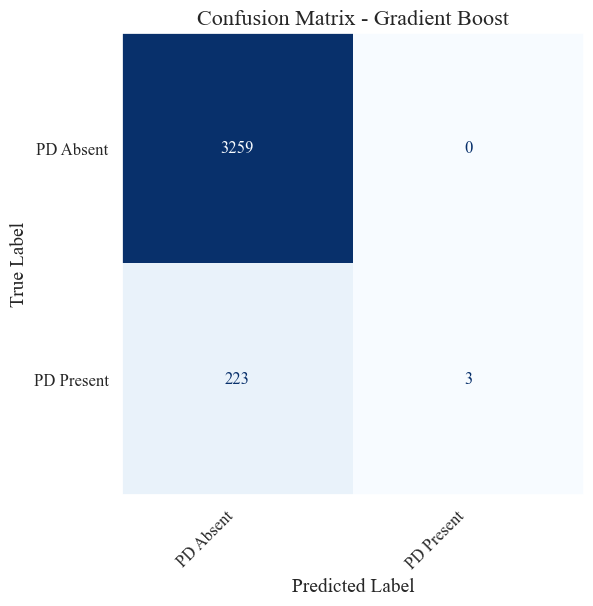

In [63]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
plt.rcParams['font.family']='Times New Roman'
# Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
gb_train = round(gb.score(X_train, y_train) * 100, 2)
gb_accuracy = round(accuracy_score(y_pred_gb, y_test) * 100, 2)

# Calculate Matthews coefficient of correlation
mcc_gb = matthews_corrcoef(y_test, y_pred_gb)

print("Training Accuracy    :", gb_train, "%")
print("Model Accuracy Score :", gb_accuracy, "%")
print("Matthews Coefficient:", mcc_gb)
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n", classification_report(y_test, y_pred_gb))
print("\033[1m--------------------------------------------------------\033[0m")
cm = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PD Absent', 'PD Present'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues',colorbar=False)
sns.set(font_scale=1)
# Set background color and grid visibility
ax.set_facecolor('white')
ax.grid(False)

# Set tick labels without cutting off text
tick_labels = ['PD Absent', 'PD Present']
disp.ax_.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
disp.ax_.set_yticklabels(tick_labels,fontsize=12)

# Set axis labels and title
plt.title('Confusion Matrix - Gradient Boost',fontsize=16)
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('True Label',fontsize=14)


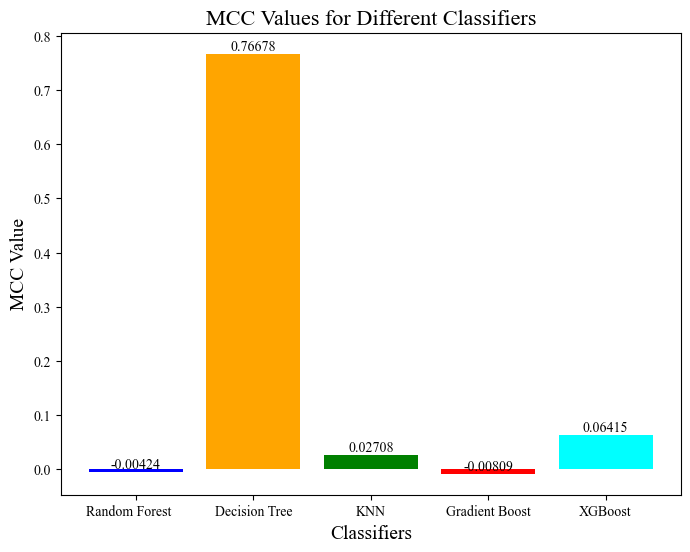

In [39]:
mcc_values = [mcc_rf, mcc_dt, mcc_knn, mcc_gb, mcc_xgb]  # Replace with your actual MCC values

# Define colors for each bar
colors = ['blue', 'orange', 'green', 'red','cyan']  # Replace with your desired colors

# Round MCC values to two decimal places
rounded_mcc_values = [round(mcc, 5) for mcc in mcc_values]

# Plot the MCC values with different colors
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(mcc_values)), mcc_values, color=colors)
plt.xlabel('Classifiers',fontsize=14)
plt.ylabel('MCC Value',fontsize=14)
plt.title('MCC Values for Different Classifiers',fontsize=16)
plt.xticks(range(len(mcc_values)), ['Random Forest    ', 'Decision Tree', 'KNN', 'Gradient Boost', 'XGBoost'])

# Add rounded MCC values as text labels on each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(rounded_mcc_values[i]), ha='center', va='bottom')

plt.show()





